<a href="https://colab.research.google.com/github/paulinapglz99/ToolingSystemsBiology/blob/main/BuildTHEbigTable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create the main table with serum titres and associated information

In [ ]:
R.version.string

[1] "R version 4.3.1 (2023-06-16)"

#### Load libraries

In [ ]:
library(stringr)


#### Function definitions

In [ ]:
getDate<-function(string) {
    date_pattern <- "\\b(?:\\d{1,2}[-/.\\s])?\\d{1,2}[-/.\\s]\\d{2,4}\\b|\\b\\d{4}[-/.\\s]\\d{1,2}[-/.\\s]\\d{1,2}\\b|\\b\\w+\\s\\d{1,2},?\\s\\d{4}\\b|\\b\\d{1,2}\\s\\w+\\s\\d{4}\\b"
    date_string <- str_extract_all(string, date_pattern)[[1]]
    date_string<-as.character(as.Date(date_string,tryFormats=c("%Y-%m-%d","%b %d %Y") ) )
    return(date_string)
}

getPlateBackground<-function(plate) {
    m<-mean(t(plate[12,1:8]))
    s<-sd(t(plate[12,1:8]))
    background<-data.frame(plate_bg_mean=m,
                           plate_bg_sd=s,
                          plate_bg_sd=m+2*s)
    return(background)
    }

getSerumDilutionAndTitre<-function(plate,c,threshold) {
    serum<-colnames(plate)[c]
    d<-NA
    ttr<-0
    if (length(which(plate[,c]>threshold))>=1) {
        for (i in 12:1) { if (plate[i,c]>threshold) break;  }
        d<-plate[i,9]
        ttr<-1/plate[i,9]
    }
    return( data.frame(serum=serum,
                   superthreshold_dilution=d,
                   raw_titre1=ttr   )
           )
    }


##### Model fitting functions

In [ ]:
# The function f is the Michaelis-Menten/Langmuir isotherm function
# whose parameters have a mechanistic interpretation in terms of
# binding sites, binding affinity, binding site independence, etc.
f<- function(x,a,b,c) {
    return(c+a*x/(b+x))
}

# The function g is an arbitrary sigmoidal curve obtained from shifting
# and rescaling the arctan function; the parameters have no underlying
# physical interpretation.
g<-function(x,a,b,c,d) {
    return(  c+a*((atan((x-b)*d)+ (pi/2))/pi ))
}

In [ ]:
get_f_fittingResults<-function (table,c) {
    # store the c column in the table in a new 2-by-12 dataframe called data
    data<-data.frame(dilution=table[,9],signal=table[,c])

    # set control of maxiter and minfactor
    nlc <- nls.control(maxiter = 150,minFactor=10^-6)

    # get the maximum and minimum signal in the whole table
    plate_max_signal=max(table[,1:8])
    plate_min_signal=min(table[,1:8])
    plate_half_signal=(plate_min_signal+plate_max_signal)*0.5
    # set the starting parameter values
    min_signal=min(data$signal)
    max_signal=max(data$signal)
    half_max_signal=mean(c(max_signal,min_signal))
    for (i in 1:12) {
        if (data$signal[i]<half_max_signal) break
        }
    half_maximal_dilution=mean(data$dilution[(i-1):i])

    # do the fitting of function f to data with start parameters
    # We consider two scenarios:
    # First, if the maximum of the signal in data is smaller than
    if (max_signal<plate_half_signal) {
        start_parameters=list(b=half_maximal_dilution, c=min_signal)
        fit<-nls(signal ~ f(dilution,plate_max_signal-plate_min_signal,b,c), data,start=start_parameters,control=nlc)
        a=plate_max_signal-plate_min_signal
        b=coef(fit)[["b"]]
        c=coef(fit)[["c"]]
    } else {
        start_parameters=list(a=max_signal-min_signal, b=half_maximal_dilution,c=min_signal)
        fit<-nls(signal ~ f(dilution,a,b,c), data,start=start_parameters,control=nlc)
        a=coef(fit)[["a"]]
        b=coef(fit)[["b"]]
        c=coef(fit)[["c"]]
        }

    # do stats on fitting residuals
    residuals<-data$signal-predict(fit,list(dilution=data$dilution))
    residuals.mean=mean(residuals)
    residuals.sd=sd(residuals)
    residuals.regress<-lm(residuals ~ log10(data$dilution)  )

    residuals.regress.intersect<-coef(residuals.regress)[[1]]
    residuals.regress.slope<-coef(residuals.regress)[[2]]
    residuals.regress.Rsquared<-summary(residuals.regress)$r.squared
    # create data frame with fitting parameters and residuals'stats
    result<-data.frame(f_a=a,f_b=b,f_c=c,
                       f_res_mean=residuals.mean,
                       f_res_sd=residuals.sd,
                       f_res_regress_intersect=residuals.regress.intersect,
                       f_res_regress_slope=residuals.regress.slope,
                       f_res_regress_Rsquared=residuals.regress.Rsquared,
                       f_rawtitre=1/b
                      )
    # return the result
    return (result)
    }

In [ ]:
get_g_fittingResults<-function (table,c) {
    # store the c column in the table in a new 2-by-12 dataframe called data
    data<-data.frame(dilution=table[,9],signal=table[,c])

    # set control of maxiter and minfactor
    nlc <- nls.control(maxiter = 1000,minFactor=10^-7)

    # get the maximum and minimum signal in the whole table
    plate_max_signal=max(table[,1:8])
    plate_min_signal=min(table[,1:8])
    plate_half_signal=(plate_min_signal+plate_max_signal)*0.5
    # set the starting parameter values
    min_signal=min(data$signal)
    max_signal=max(data$signal)
    half_max_signal=mean(c(max_signal,min_signal))
    for (i in 1:12) {
        if (data$signal[i]<half_max_signal) break
        }
    half_maximal_dilution=mean(data$dilution[(i-1):i])

    # do the fitting of function f to data with start parameters
    # We consider two scenarios:
    # First, if the maximum of the signal in data is smaller than
    if (max_signal<plate_half_signal) {
        start_parameters=list(b=log10(half_maximal_dilution), c=min_signal,d=2)
        fit<-nls(signal ~ g(log10(dilution),plate_max_signal-plate_min_signal,b, c,d), data,start=start_parameters,control=nlc)
        a=plate_max_signal-plate_min_signal
        b=coef(fit)[["b"]]
        c=coef(fit)[["c"]]
        d=coef(fit)[["d"]]
    } else {
        start_parameters=list(a=max_signal-min_signal, b=log10(half_maximal_dilution),c=min_signal,d=2)
        fit<-nls(signal ~ g(log10(dilution),a,b,c,d), data,start=start_parameters,control=nlc)
        a=coef(fit)[["a"]]
        b=coef(fit)[["b"]]
        c=coef(fit)[["c"]]
        d=coef(fit)[["d"]]
        }

    # do stats on fitting residuals
    residuals<-data$signal-predict(fit,list(dilution=data$dilution))
    residuals.mean=mean(residuals)
    residuals.sd=sd(residuals)
    residuals.regress<-lm(residuals ~ log10(data$dilution)  )

    residuals.regress.intersect<-coef(residuals.regress)[[1]]
    residuals.regress.slope<-coef(residuals.regress)[[2]]
    residuals.regress.Rsquared<-summary(residuals.regress)$r.squared
    # create data frame with fitting parameters and residuals'stats
    result<-data.frame(g_a=a,g_b=b,g_c=c,g_d=d,
                       g_res_mean=residuals.mean,
                       g_res_sd=residuals.sd,
                       g_res_regress_intersect=residuals.regress.intersect,
                       g_res_regress_slope=residuals.regress.slope,
                       g_res_regress_Rsquared=residuals.regress.Rsquared,
                       g_rawtitre=1/ 10^b
                      )
    # return the result
    return (result)
    }

### Build the table with serum titres and associated information

In [ ]:
setwd("~/Desktop/ToolingUp2024WorkFolder/RawData/")
datafolders<-list.dirs(path = ".", full.names = FALSE, recursive = FALSE)

sera_titre_table<-data.frame(serum=NA,lab=NA,date=NA,
                       plate=NA,plate_bg_mean=NA,plate_bg_sd=NA,plate_bg_threshold=NA,
                       superthreshold_dilution=NA,raw_titre1=NA,titre1=NA,
                       f_a=NA,f_b=NA,f_c=NA,f_res_mean=NA,f_res_sd=NA,
                       f_res_regress_intersect=NA,f_res_regress_slope=NA,f_res_regress_Rsquared=NA,
                       f_rawtitre=NA,f_titre=NA,
                       g_a=NA,g_b=NA,g_c=NA,g_d=NA,g_res_mean=NA,g_res_sd=NA,
                       g_res_regress_intersect=NA,g_res_regress_slope=NA,g_res_regress_Rsquared=NA,
                       g_rawtitre=NA,g_titre=NA
                             )

table_entry_template<-sera_titre_table


#Iterate on folders
for (folder in datafolders) {
    print(paste("Analysing folder ",folder))
    fnames<-dir(folder) # Get the list of files in folder
    #Iterate on files
    for (fname in fnames) {
        #Set the file's basename
        fbasename<-sub('\\.csv$', '', fname)
        #Set the file's path
        fpath<-paste(folder,fname,sep="/")
        #Read the file as plate
        plate<-read.csv(fpath)

        #Calculate plate background mean, sd and threshold
        background<-getPlateBackground(plate)



        #Save the row of the last entry in the sera_titre_table
        last<-nrow(sera_titre_table)

        #Iterate on serum columns in the plate table
        for (c in 1:8 ) {

            #Initilize table_entry
            table_entry<-table_entry_template
            #Fill table_entry with info with folder and file names
            table_entry$lab<-folder
            table_entry$date<-getDate(fbasename)
            spacesplit<-strsplit(fbasename," ")[[1]]
            table_entry$plate<-spacesplit[length(spacesplit)]
            #Fill table entry with background
            table_entry[,c("plate_bg_mean","plate_bg_sd","plate_bg_threshold")]<-background

            #Fill table entry with serum id, super threshold dilution and raw titre1
            table_entry[,c("serum","superthreshold_dilution","raw_titre1")]<-getSerumDilutionAndTitre(plate,c,table_entry$plate_bg_threshold)

            #Fill table entry with the results of fitting function f
            table_entry[,c("f_a","f_b","f_c","f_res_mean","f_res_sd",
                       "f_res_regress_intersect","f_res_regress_slope","f_res_regress_Rsquared",
                       "f_rawtitre")]<-get_f_fittingResults(plate,c)

            #Fill table entry with the results of fitting function g

            table_entry[,c("g_a","g_b","g_c","g_d","g_res_mean","g_res_sd",
                       "g_res_regress_intersect","g_res_regress_slope","g_res_regress_Rsquared",
                       "g_rawtitre")]<-get_g_fittingResults(plate,c)

            # Add the table_entry to the bottom of sera titre table
            sera_titre_table<-rbind(sera_titre_table,table_entry)
            }
            # Normalise across plates by dividing raw titre in each plate by the mean reference titre

            ref_titre1_mean<-mean(sera_titre_table$raw_titre1[last+(1:2)])
            sera_titre_table$titre1[last+(1:8)]<-sera_titre_table$raw_titre1[last+(1:8)]/ref_titre1_mean

            ref_f_titre_mean<-mean(sera_titre_table$f_rawtitre[last+(1:2)])
            sera_titre_table$f_titre[last+(1:8)]<-sera_titre_table$f_rawtitre[last+(1:8)]/ref_f_titre_mean

            ref_g_titre_mean<-mean(sera_titre_table$g_rawtitre[last+(1:2)])
            sera_titre_table$g_titre[last+(1:8)]<-sera_titre_table$g_rawtitre[last+(1:8)]/ref_g_titre_mean

        }

    }

# Clean the table by eliminating the first row full of NA
sera_titre_table<-sera_titre_table[-1,]


[1] "Analysing folder  Demengeot"
[1] "Analysing folder  Howard"
[1] "Analysing folder  HowardNew"
[1] "Analysing folder  Vilanova"


[1] "Vilanova"

[1] "2023-12-22 plate_6"

[1] 8

[1] 5624

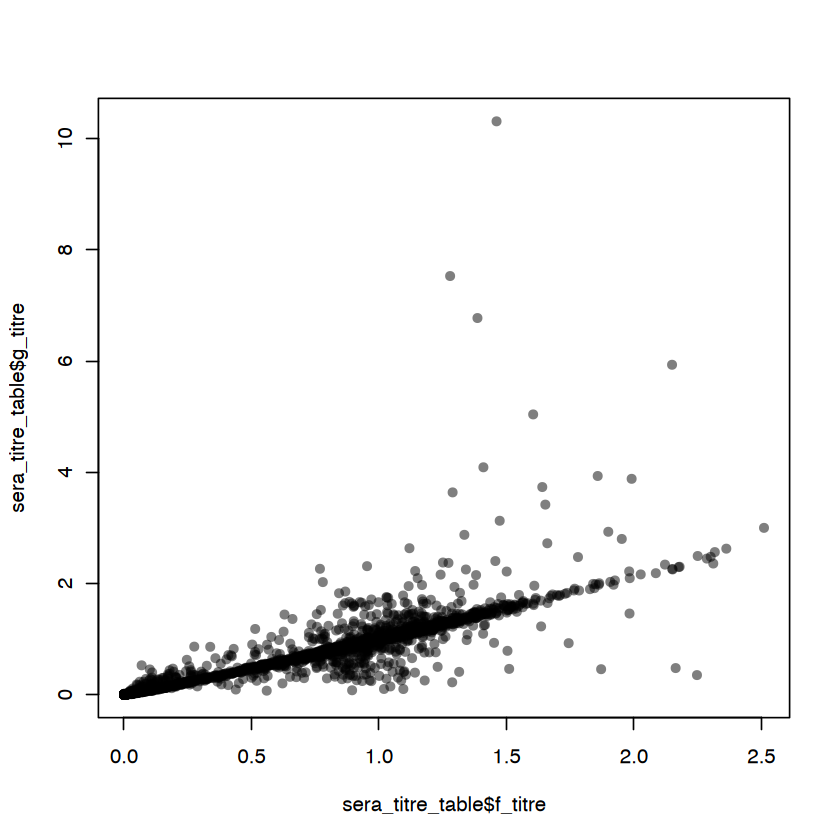

In [ ]:

folder
fbasename
c
nrow(sera_titre_table)
plot(sera_titre_table$f_titre,sera_titre_table$g_titre,pch=16,col=rgb(0,0,0,.5))

### Save the table

In [ ]:
setwd("~/Desktop/ToolingUp2024WorkFolder/Data")
write.csv(sera_titre_table,"Sera titre table.csv")

### Analyse infected individuals serum titres

[1] 2820

[1] 1406

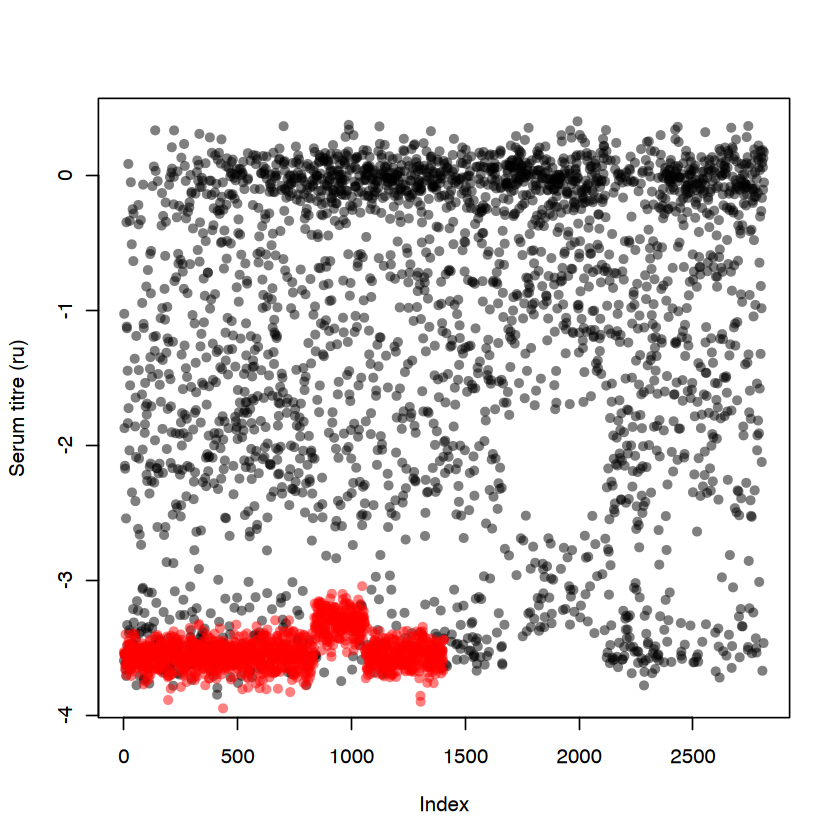

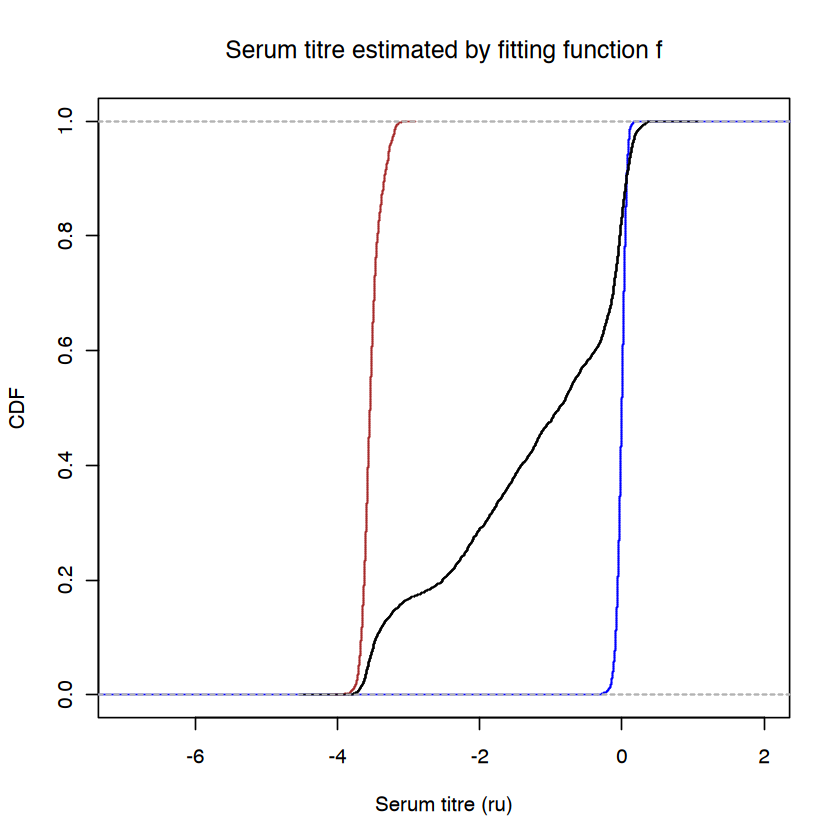

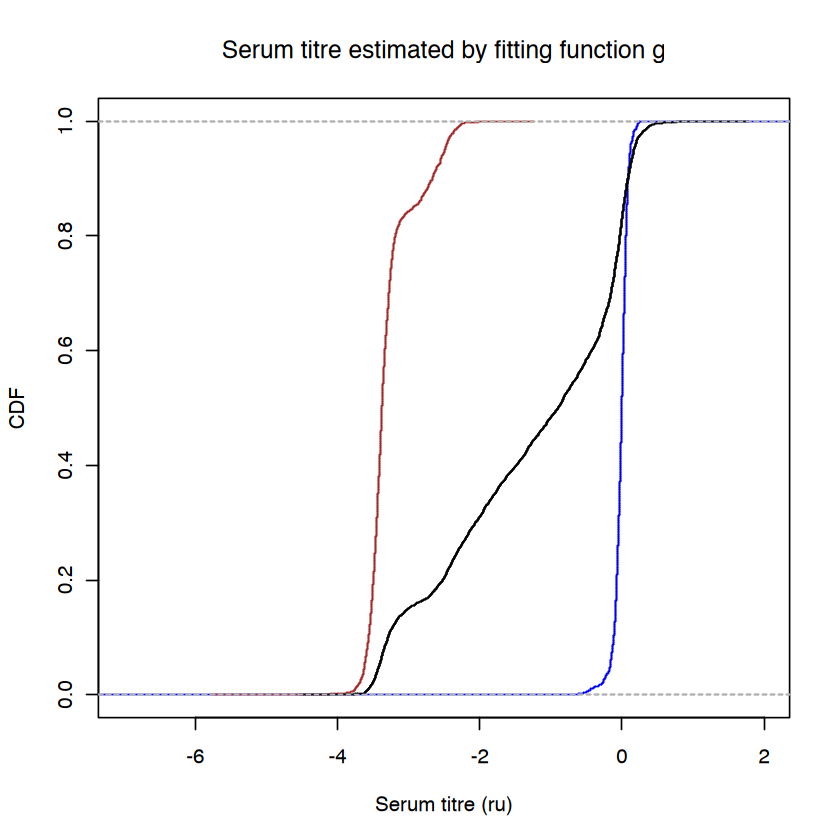

In [ ]:
inrex<-grep("R",sera_titre_table$serum)
infex<-grep("I",sera_titre_table$serum)
inbex<-grep("C",sera_titre_table$serum)
length(index)
length(inbex)


plot(log10(sera_titre_table$f_titre[infex]),pch=16,col=rgb(0,0,0,0.5),ylab="Serum titre (ru)")
points(log10(sera_titre_table$f_titre[inbex]),pch=16,col=rgb(1,0,0,0.5) )


plot(ecdf(log10(sera_titre_table$f_titre[inrex])),col="blue",
     xlab="Serum titre (ru)",ylab="CDF",xlim=c(-7,2),main="Serum titre estimated by fitting function f")
lines(ecdf(log10(sera_titre_table$f_titre[inbex])),col="brown")
lines(ecdf(log10(sera_titre_table$f_titre[infex])),col="black")

plot(ecdf(log10(sera_titre_table$g_titre[inrex])),col="blue",
     xlab="Serum titre (ru)",ylab="CDF",xlim=c(-7,2),main="Serum titre estimated by fitting function g")
lines(ecdf(log10(sera_titre_table$g_titre[inbex])),col="brown")
lines(ecdf(log10(sera_titre_table$g_titre[infex])),col="black")



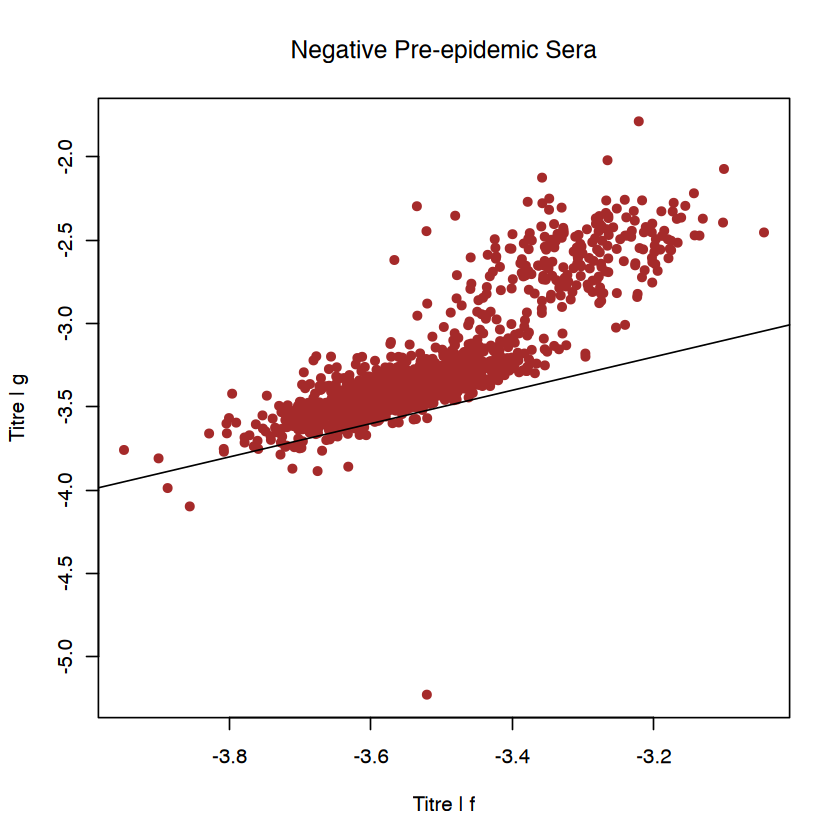

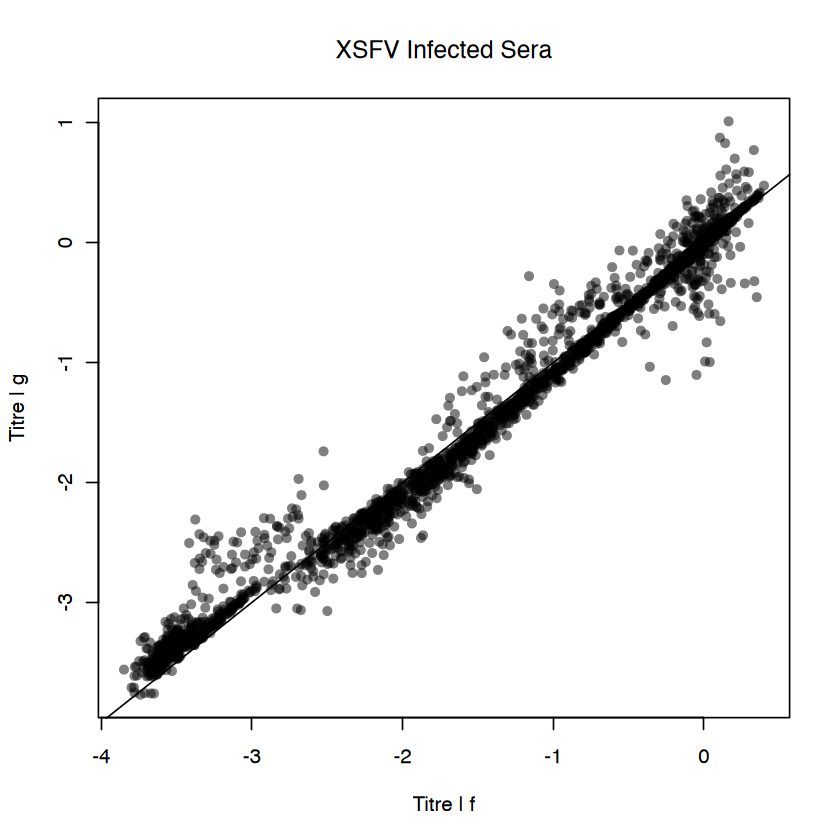

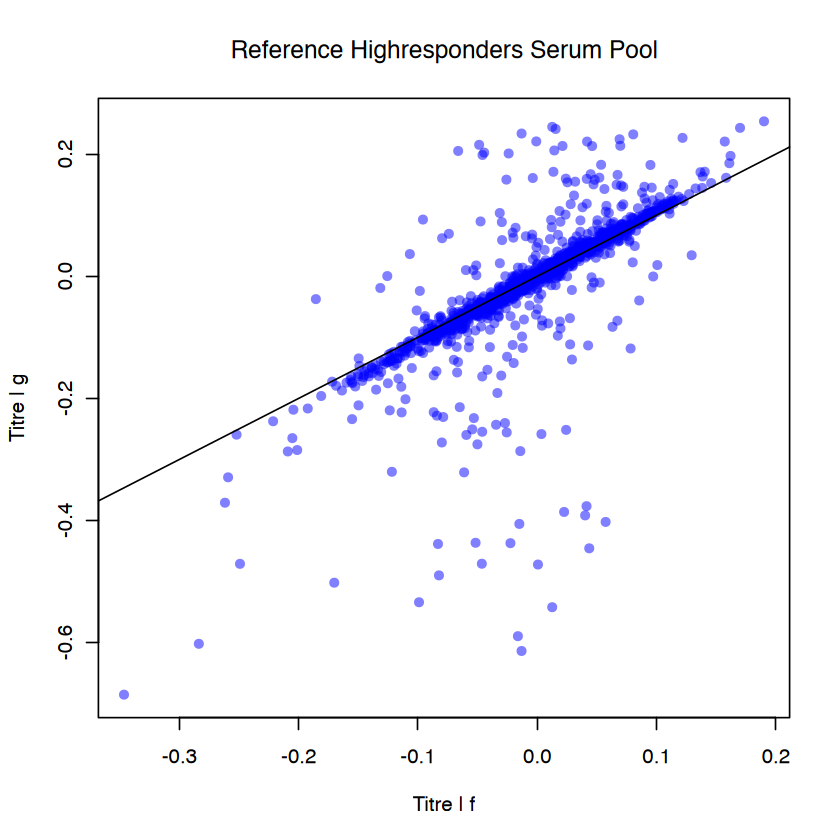

In [ ]:
plot(log10(sera_titre_table$f_titre[inbex]),log10(sera_titre_table$g_titre[inbex]),
     pch=16,col="brown",xlab="Titre | f",ylab="Titre | g",main="Negative Pre-epidemic Sera")
abline(a=0,b=1)

plot(log10(sera_titre_table$f_titre[infex]),log10(sera_titre_table$g_titre[infex]),
     pch=16,col=rgb(0,0,0,0.5),xlab="Titre | f",ylab="Titre | g",main="XSFV Infected Sera")
abline(a=0,b=1)

plot(log10(sera_titre_table$f_titre[inrex]),log10(sera_titre_table$g_titre[inrex]),
     pch=16,col=rgb(0,0,1,0.5),xlab="Titre | f",ylab="Titre | g",main="Reference Highresponders Serum Pool")
abline(a=0,b=1)

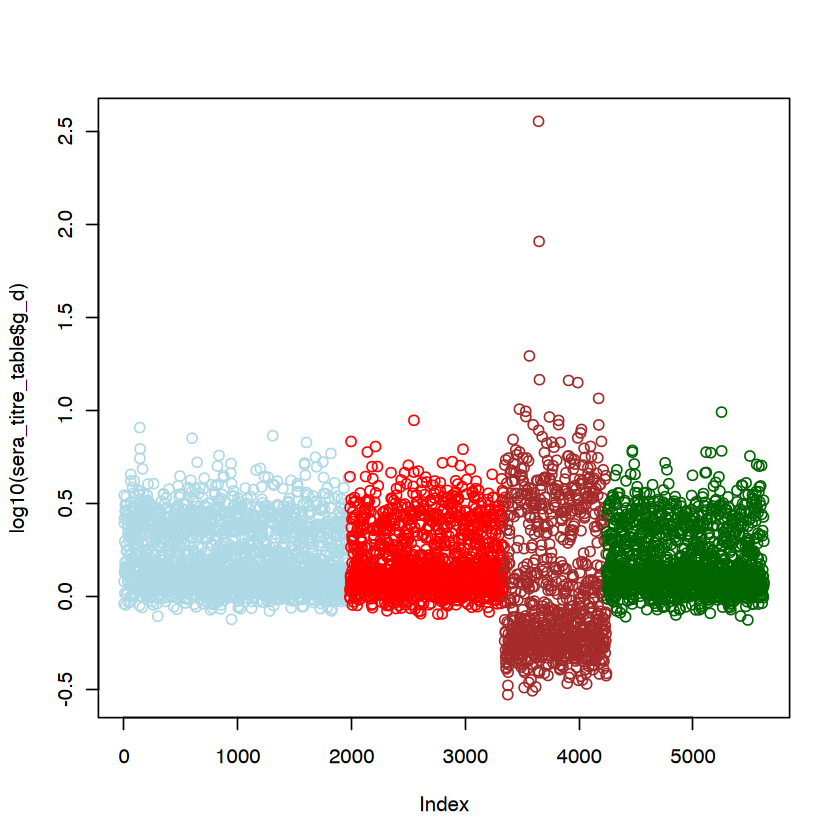

In [ ]:
labcolors<-c("lightblue","red","brown","darkgreen")
plot(log10(sera_titre_table$g_d),col=labcolors[as.factor(sera_titre_table$lab)])


In [ ]:
require(Rtsne)

Loading required package: Rtsne



In [ ]:
colnames(sera_titre_table)[11:ncol(sera_titre_table)]


[1] "f_a"                     "f_b"                    
 [3] "f_c"                     "f_res_mean"             
 [5] "f_res_sd"                "f_res_regress_intersect"
 [7] "f_res_regress_slope"     "f_res_regress_Rsquared" 
 [9] "f_rawtitre"              "f_titre"                
[11] "g_a"                     "g_b"                    
[13] "g_c"                     "g_d"                    
[15] "g_res_mean"              "g_res_sd"               
[17] "g_res_regress_intersect" "g_res_regress_slope"    
[19] "g_res_regress_Rsquared"  "g_rawtitre"             
[21] "g_titre"

In [ ]:
sera.tsne100<-Rtsne(sera_titre_table[,11:ncol(sera_titre_table)],check_duplicates = TRUE,perplexity=100)
sera.tsne300<-Rtsne(sera_titre_table[,11:ncol(sera_titre_table)],check_duplicates = TRUE,perplexity=300)


In [ ]:
sera_titre_table$class=NA
sera_titre_table$class[grep("R", sera_titre_table$serum)]<-"R"
sera_titre_table$class[grep("I", sera_titre_table$serum)]<-"I"
sera_titre_table$class[grep("C", sera_titre_table$serum)]<-"C"
unique(sera_titre_table$class)
classcolors<-c("gray","red","blue")

[1] "R" "C" "I"

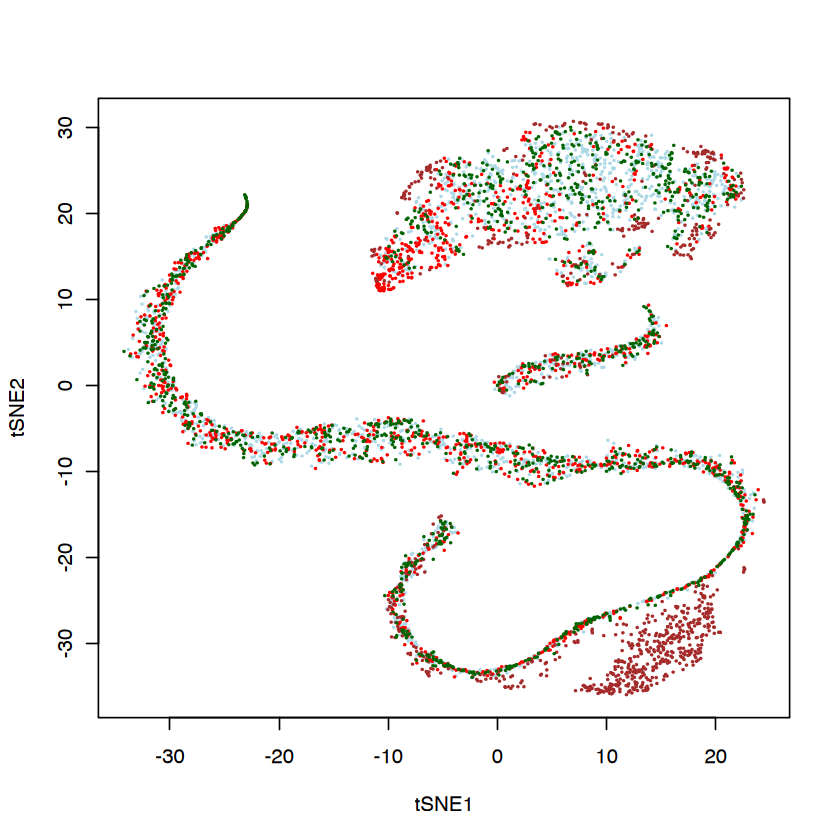

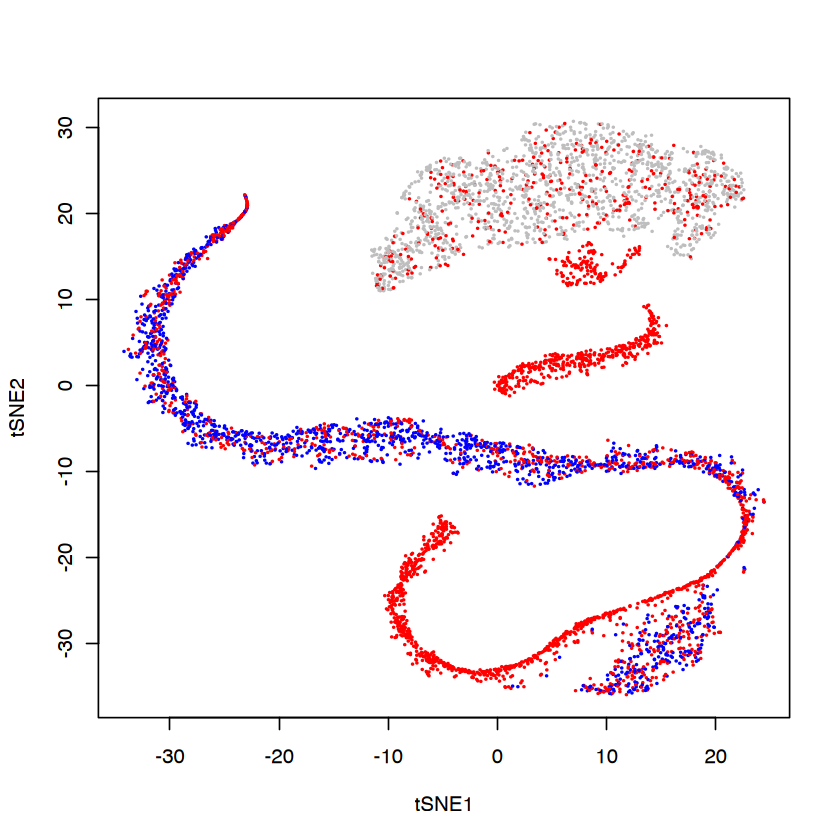

In [ ]:
plot(sera.tsne100 $Y[,1], sera.tsne100 $Y[,2],pch=19,cex=0.1,
     xlab="tSNE1",ylab="tSNE2",col=labcolors[as.factor(sera_titre_table$lab)])

plot(sera.tsne100 $Y[,1], sera.tsne100 $Y[,2],pch=19,cex=0.1,
     xlab="tSNE1",ylab="tSNE2",col=classcolors[as.factor(sera_titre_table$class)])


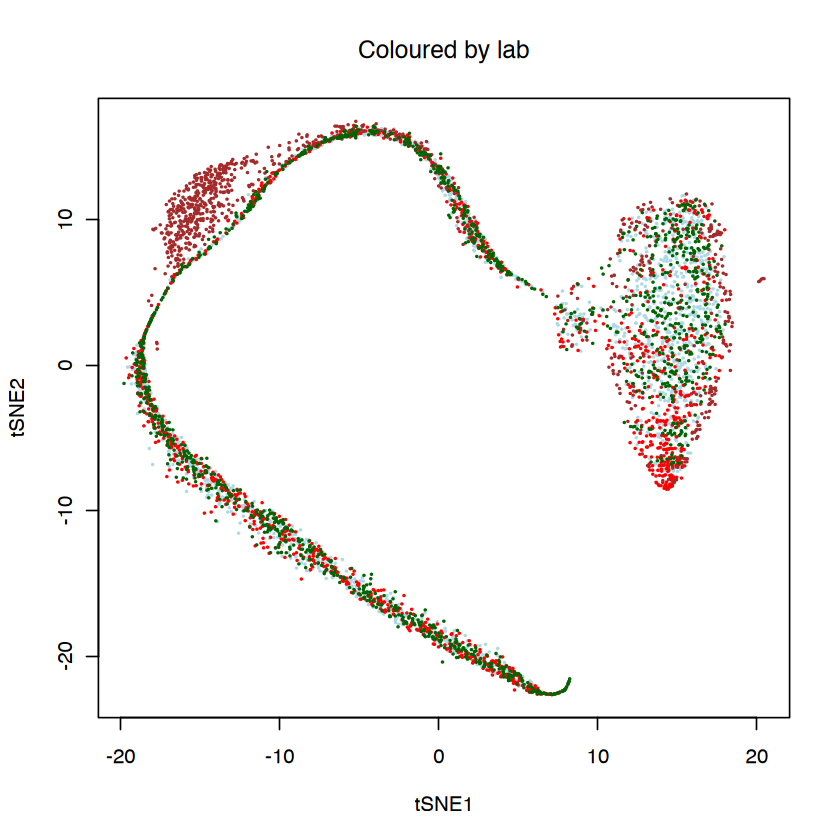

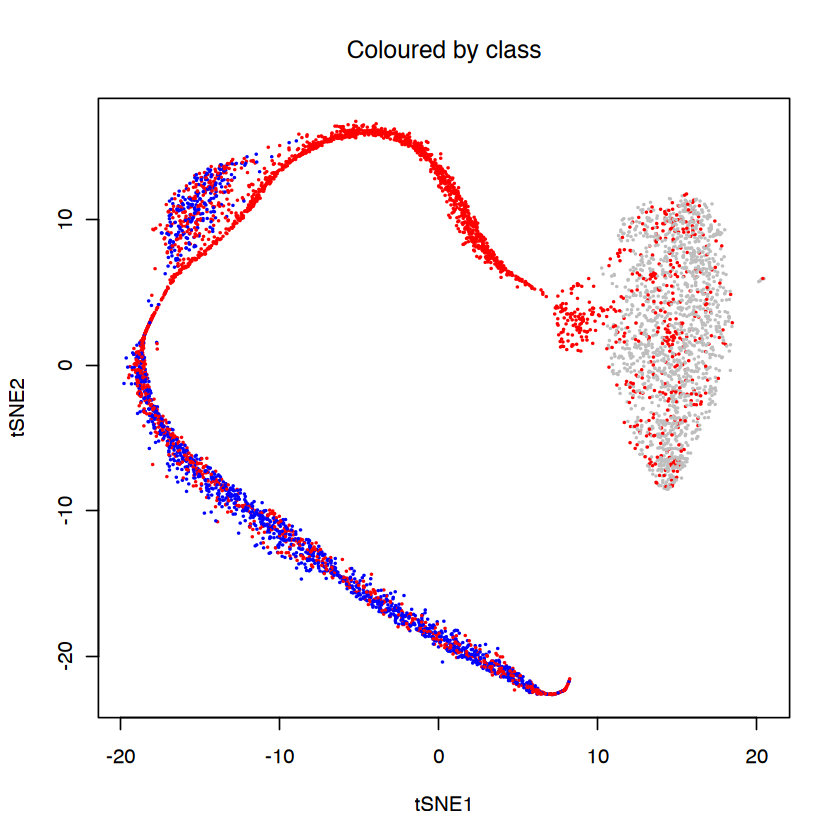

In [ ]:
plot(sera.tsne300 $Y[,1], sera.tsne300 $Y[,2],pch=19,cex=0.1,
     xlab="tSNE1",ylab="tSNE2",col=labcolors[as.factor(sera_titre_table$lab)],
    main="Coloured by lab")

plot(sera.tsne300 $Y[,1], sera.tsne300 $Y[,2],pch=19,cex=0.1,
     xlab="tSNE1",ylab="tSNE2",col=classcolors[as.factor(sera_titre_table$class)],main="Coloured by class")



In [ ]:
#data.frame(sera_titre_table$class,classcolors[as.factor(sera_titre_table$class)])